# Packages

In [1]:
import ee
import geemap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Open Nighttime Lights\\04_Charting'

# Extract time series data and convert to pandas dataframe

Google Earth Engine (GEE) provides a User-Interface (UI) module for creating charts directly in the Editor. It’s built on the Google Visualization API if you’re familiar with that in other Google products. Unfortunately, the UI module is not availabe through the Python API, including the `ee` library, but we’ll introduce some Python-centric approaches to extracting and visualizing data. As an additional constraint, plotting data in this manner requires you to actually extract data from its location on Google servers (“in the cloud”) to your local machine for visualization. Just as with any data extraction, there are constraints to how much data you can actually move, so it will be prohibitive to plot very large scenes.

In this exercise, we will create a simple time series for VIIRS-DNB values at a specific location. We will extract the data from our raster file of VIIRS-DNB radiance and convert it into a pandas dataframe in our local computing space so that we can use a plot libraries, matplotlib and seaborn to make our line graph. First we define our point of interest: the location of Seoul Olympic Stadium (a.k.a. Jamsil Olympic Stadium). Technically we’ll pick a lat/lon coordinate in the stadium and create a 500m buffer around it. Then we’ll grab a collection of VIIRS-DNB monthly composites from January 2014 to May 2020.

In [2]:
# Identify a 500m buffer around a POI
poi = ee.Geometry.Point(127.072483, 37.515817).buffer(500)

viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')\
        .filterDate('2014-01-01', '2020-05-31')
viirs

Name,Description
avg_rad,Average DNB radiance values.
cf_cvg,Cloud-free coverages; the total number of observations that went into each pixel. This band can be used to identify areas with low numbers of observations where the quality is reduced.


To make a time series, we need to get all the values in our collection using the map function. We’ll create a custom function in Python that takes a single image as an input and reduces the data in a given region (our point of interest in this case).

We’ll get the mean of the pixels in our region and set the scale to 30. We’ll use the `avg_rad` band.

We’ll then need to set this reduced info as a property (we’ll call it “mean”) in our image so that the output of our function is to get the mean radiance of a particular region, and add this as a property on our image along with the date.

In [3]:
def poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = poi, scale = 30).get('avg_rad')
    return img.set('date', img.date().format()).set('mean', mean)

# Map this function to every image in our collection to get a new ImageCollection, but now each image has the mean value for the region of interest and date
poi_reduced_imgs = viirs.map(poi_mean)
poi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.buffer",
    "arguments": {
      "distance": {
        "constantValue": 500
      },
      "geometry": {
        "functionInvocationValue": {
          "functionName": "GeometryConstructors.Point",
          "arguments": {
            "coordinates": {
              "constantValue": [
                127.072483,
                37.515817
              ]
            }
          }
        }
      }
    }
  }
})

To convert to a pandas dataframe, we dont want an ImageCollection; however, so we will reduce our images to a list of lists:
- For each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
- Each of these lists are themselves elements in our outer list, which is what we’ll convert to a dataframe

In [4]:
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)
nested_list

In [5]:
# This can be turned into a DataFrame
df = pd.DataFrame(nested_list.getInfo(), columns = ['date', 'mean'])
df

,date,mean
0,2014-01-01T00:00:00,61.927905
1,2014-02-01T00:00:00,51.591837
2,2014-03-01T00:00:00,51.378309
3,2014-04-01T00:00:00,59.228776
4,2014-05-01T00:00:00,63.510432
...,...,...
72,2020-01-01T00:00:00,44.474762
73,2020-02-01T00:00:00,38.256775
74,2020-03-01T00:00:00,46.065028
75,2020-04-01T00:00:00,45.411734


In [6]:
# Set our date column to be the index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,mean
date,
2014-01-01,61.927905
2014-02-01,51.591837
2014-03-01,51.378309
2014-04-01,59.228776
2014-05-01,63.510432
...,...
2020-01-01,44.474762
2020-02-01,38.256775
2020-03-01,46.065028


# Create a time series graph for VIIRS-DNB from Jan 2014 to May 2020 for Seoul Olympic Stadium

In [7]:
# Look at Korea
koreaMap = geemap.Map()
koreaMap.centerObject(poi, zoom = 15)
koreaMap.add_basemap('SATELLITE')
koreaMap.addLayer(poi, {}, 'Seoul Olympics Stadium')
koreaMap.addLayerControl()
koreaMap

Map(center=[37.5158175129507, 127.07248301794745], controls=(WidgetControl(options=['position', 'transparent_b…

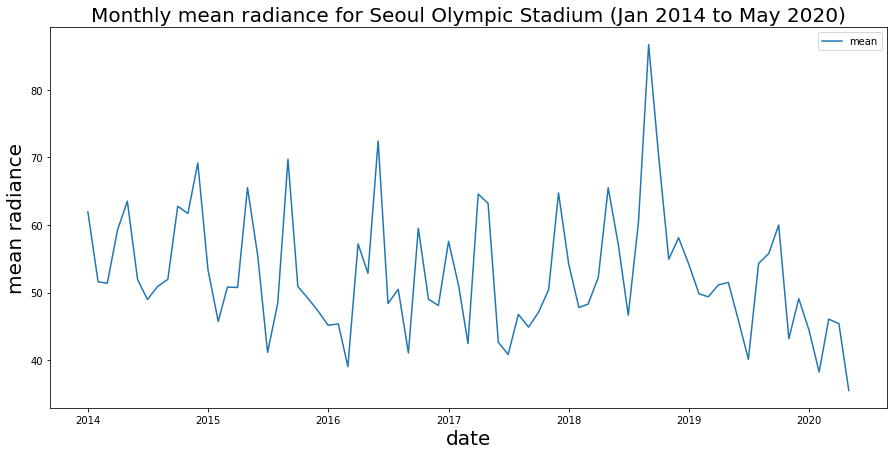

In [8]:
# Create a figure
fig, ax = plt.subplots(figsize = (15, 7))

# Create a plot by setting our dataframe to the data argument
sns.lineplot(data = df, ax = ax)

# Set labels and title
ax.set_ylabel('mean radiance', fontsize = 20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title('Monthly mean radiance for Seoul Olympic Stadium (Jan 2014 to May 2020)', fontsize = 20)

plt.show()

Brief observations: We see some strong seasonal patterns here (peaks and values), which is perhaps not too surprising for a sports stadium. We also see a spike in late 2018 as well as the drop-off in early 2020 that is very likely an indication of COVID-19 impacts.

Just out of curiousity…what is that spike? With dataframes we can easily find the date of that peak using the `.idxmax()` method to get the index (which is the month) of our maximum value.

In [9]:
df.idxmax()

mean   2018-09-01
dtype: datetime64[ns]

Hm, what was happening in September 2018? As it happens, 2018 is the 30th anniversary of the Seoul Olympics…perhaps there were a lot of events and concerts?

With our time series data, we can also smooth our time series (this is again, easy with Pandas. We’ll get a moving avg of 12 months to smooth our data out and see overall trends):

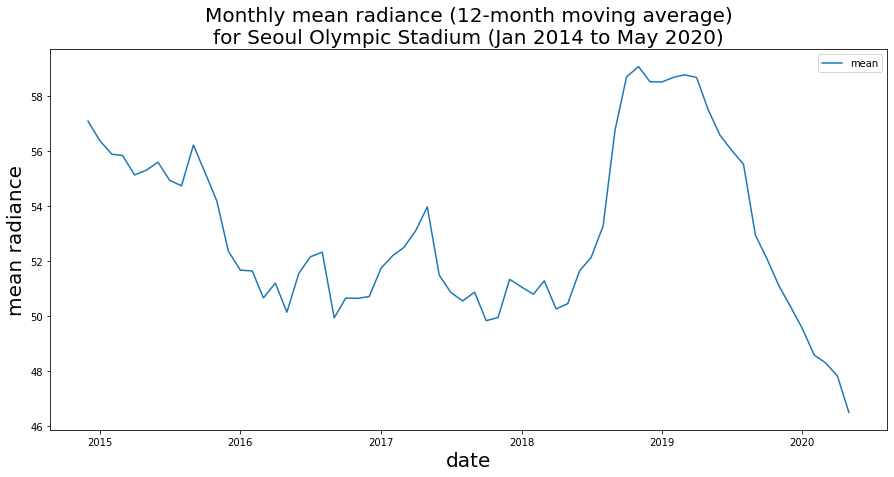

In [10]:
fig, ax = plt.subplots(figsize = (15, 7))

# Plot the moving average and set a window of 12 months
window = 12
sns.lineplot(data = df.rolling(window).mean(), ax = ax)

# Set labels and title
ax.set_ylabel('mean radiance', fontsize = 20)
ax.set_xlabel('date', fontsize = 20)
ax.set_title(f'Monthly mean radiance ({window}-month moving average)\nfor Seoul Olympic Stadium (Jan 2014 to May 2020)', fontsize = 20)

plt.show()

We can see an overall trend that does seem to be decreasing, aside from our 2018 spike.

# Time series using Sum Of Lights from Jan 2014 to May 2020 for South Korea

We are cautious about calculating SOL for comparing regions since the scale of the reducer function can profoundly affect the aggregation; however, here we’re comparing the same region over time, so we’re comfortable using SOL.

We will use the shapefile for South Korea in GEE and instead of using our mean reducer on a point of interest, we’ll apply a sum reducer on all of South Korea. We’ll adjust the scale to 500 meters and we’ll have to set the maxPixels threshold to 1 billion.

In [11]:
# Get SK national boundary geometry
sokorea = ee.Feature(ee.FeatureCollection('FAO/GAUL/2015/level0')\
                     .filter(ee.Filter.eq('ADM0_NAME', 'Republic of Korea'))\
                        .first()).geometry()

# Revise our reducer function to get SOL for SK
def get_sokorea_sol(img):
    sol = img.reduceRegion(reducer = ee.Reducer.sum(), geometry = sokorea, scale = 500, maxPixels = 1e9)\
            .get('avg_rad')
    return img.set('date', img.date().format()).set('SOL', sol)

# Reduce collection
sokorea_sol = viirs.map(get_sokorea_sol)

# Get lists
nested_list = sokorea_sol.reduceColumns(ee.Reducer.toList(2), ['date', 'SOL']).values().get(0)

# Convert to DataFrame
soldf = pd.DataFrame(nested_list.getInfo(), columns = ['date', 'SOL'])
soldf['date'] = pd.to_datetime(soldf['date'])
soldf = soldf.set_index('date')
soldf

,SOL
date,
2014-01-01,1.713073e+06
2014-02-01,1.439154e+06
2014-03-01,1.534780e+06
2014-04-01,1.551398e+06
2014-05-01,1.649330e+06
...,...
2020-01-01,2.069103e+06
2020-02-01,2.071237e+06
2020-03-01,2.104818e+06


In [12]:
# Look at nighttime lights for SK (look at median for our entire time period for visualization)
koreaMap2 = geemap.Map()
koreaMap2.centerObject(sokorea, zoom = 7)
koreaMap2.add_basemap('SATELLITE')
koreaMap2.addLayer(sokorea, {}, 'South Korea')
koreaMap2.addLayer(viirs.select('avg_rad').median(), {'min': 0, 'max': 10}, 'VIIRS 2014-2020 mean')
koreaMap2.addLayerControl()
koreaMap2

Map(center=[36.34449219000825, 127.80177597242078], controls=(WidgetControl(options=['position', 'transparent_…

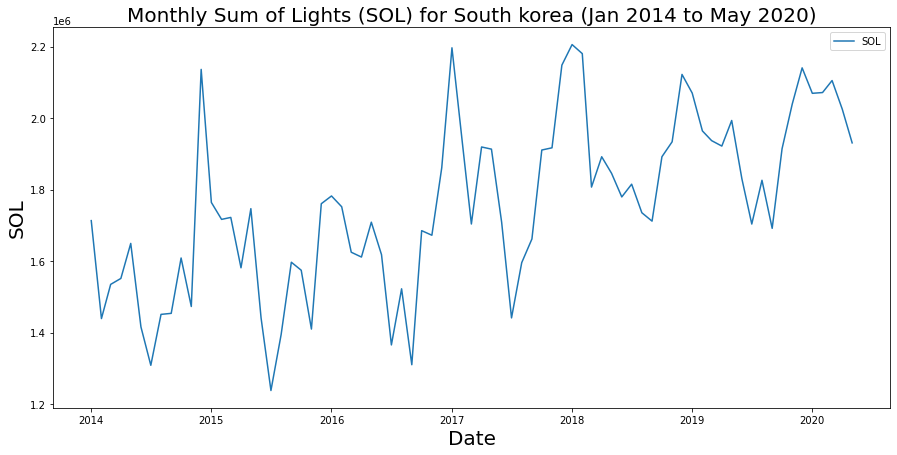

In [13]:
fig, ax = plt.subplots(figsize = (15, 7))

sns.lineplot(data = soldf, ax = ax)
ax.set_ylabel('SOL', fontsize = 20)
ax.set_xlabel('Date', fontsize = 20)
ax.set_title('Monthly Sum of Lights (SOL) for South korea (Jan 2014 to May 2020)', fontsize = 20)

plt.show()

Is the drop in 2020 an indication of lower activity or is it following a cycle? Further time series analysis, such as autocorrelation, leveraging historical data will be needed. It’s also worth considering a metric rather than SOL and perhaps scaling our data against area or disaggregating according to urban vs rural, etc.

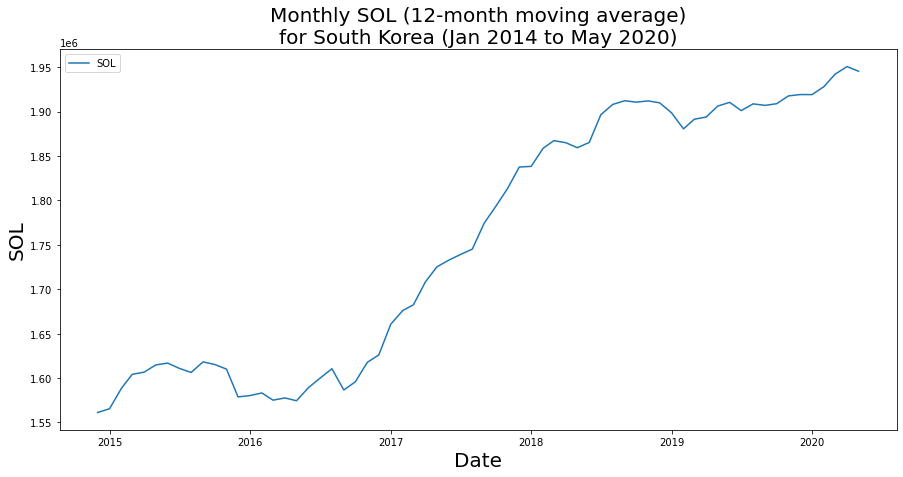

In [14]:
fig, ax = plt.subplots(figsize = (15, 7))
window = 12

sns.lineplot(data = soldf.rolling(window).mean(), ax = ax)
ax.set_ylabel('SOL', fontsize = 20)
ax.set_xlabel('Date', fontsize = 20)
ax.set_title(f'Monthly SOL ({window}-month moving average)\nfor South Korea (Jan 2014 to May 2020)', fontsize = 20)

plt.show()

Could you use what we learned with Conditional operations to split the data into separate “high” and “low” radiance time series to potential assess time series in both groups?

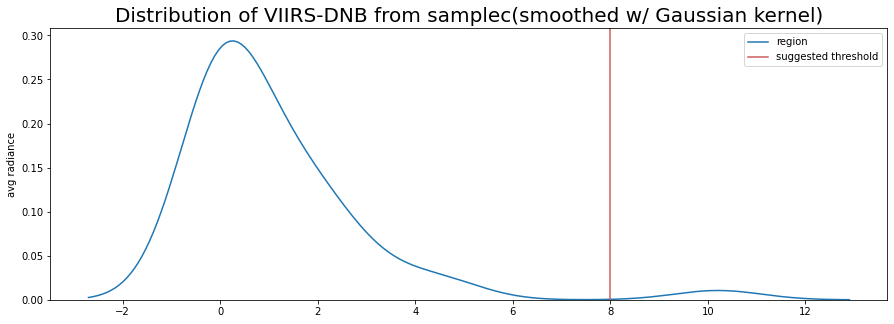

In [15]:
# Image
viirs_sk = viirs.map(lambda x: x.clip(sokorea))

viirs_median = viirs_sk.select('avg_rad').median()

arr = geemap.ee_to_numpy(viirs_median, region = sokorea)

# Histogram
fig, ax = plt.subplots(figsize = (15, 5))
sns.kdeplot(arr.flatten(), label = 'region', legend = True, ax = ax)

# Edit here
thresh = 8
ax.axvline(thresh, color = 'indianred', label = 'suggested threshold')
plt.legend(loc = 'upper right')

plt.title('Distribution of VIIRS-DNB from samplec(smoothed w/ Gaussian kernel)', fontsize = 20)
plt.ylabel('avg radiance')

plt.show()

In [16]:
zones = viirs_median.gte(thresh)

map_zones = geemap.Map()
map_zones.centerObject(sokorea, zoom = 7)
map_zones.add_basemap('SATELLITE')
map_zones.addLayer(zones.mask(zones), {}, 'Zones')
map_zones.addLayerControl()
map_zones

Map(center=[36.34449219000825, 127.80177597242078], controls=(WidgetControl(options=['position', 'transparent_…